# 中文酒店评论情感分析 - 数据探索

本笔记本将对ChnSentiCorp酒店评论数据集进行全面的探索性数据分析（EDA）。

In [8]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## 1. 数据加载与基本信息

In [2]:
# 加载数据
df = pd.read_csv('../ChnSentiCorp_htl_all.csv', encoding='utf-8')

print(f"数据集形状: {df.shape}")
print(f"\n数据集基本信息:")
print(df.info())

print(f"\n数据集前5行:")
df.head()

数据集形状: (7766, 2)

数据集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7766 entries, 0 to 7765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7766 non-null   int64 
 1   review  7765 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.5+ KB
None

数据集前5行:


,label,review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"


In [3]:
# 检查缺失值
print("缺失值统计:")
print(df.isnull().sum())

print(f"\n数据类型:")
print(df.dtypes)

print(f"\n数据集描述性统计:")
df.describe(include='all')

缺失值统计:
label     0
review    1
dtype: int64

数据类型:
label      int64
review    object
dtype: object

数据集描述性统计:


,label,review
count,7766.000000,7765
unique,NaN,7765
top,NaN,说实在的我很失望，之前看了其他人的点评后觉得还可以才去的，结果让我们大跌眼镜。我想这家酒店以...
freq,NaN,1
mean,0.685295,NaN
std,0.464428,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,1.000000,NaN
75%,1.000000,NaN


## 2. 标签分布分析

标签分布:
label
1    5322
0    2444
Name: count, dtype: int64

标签比例:
label
1    0.685295
0    0.314705
Name: proportion, dtype: float64


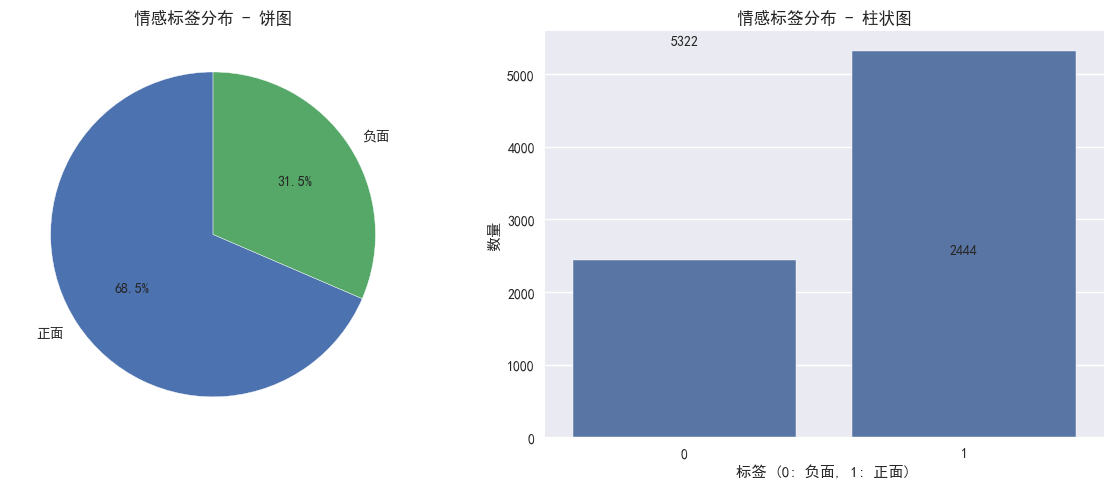

In [10]:
# 标签分布
label_counts = df['label'].value_counts()
print("标签分布:")
print(label_counts)
print(f"\n标签比例:")
print(df['label'].value_counts(normalize=True))

# 可视化标签分布
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 饼图
labels = ['正面', '负面']
axes[0].pie(label_counts.values, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('情感标签分布 - 饼图')

# 柱状图
sns.countplot(data=df, x='label', ax=axes[1])
axes[1].set_title('情感标签分布 - 柱状图')
axes[1].set_xlabel('标签 (0: 负面, 1: 正面)')
axes[1].set_ylabel('数量')

# 添加数值标签
for i, v in enumerate(label_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 3. 文本长度分析

文本长度统计:
count    7766.000000
mean      128.502447
std       143.627184
min         2.000000
25%        45.000000
50%        84.000000
75%       154.000000
max      2924.000000
Name: text_length, dtype: float64


文本长度统计:
count    7766.000000
mean      128.502447
std       143.627184
min         2.000000
25%        45.000000
50%        84.000000
75%       154.000000
max      2924.000000
Name: text_length, dtype: float64


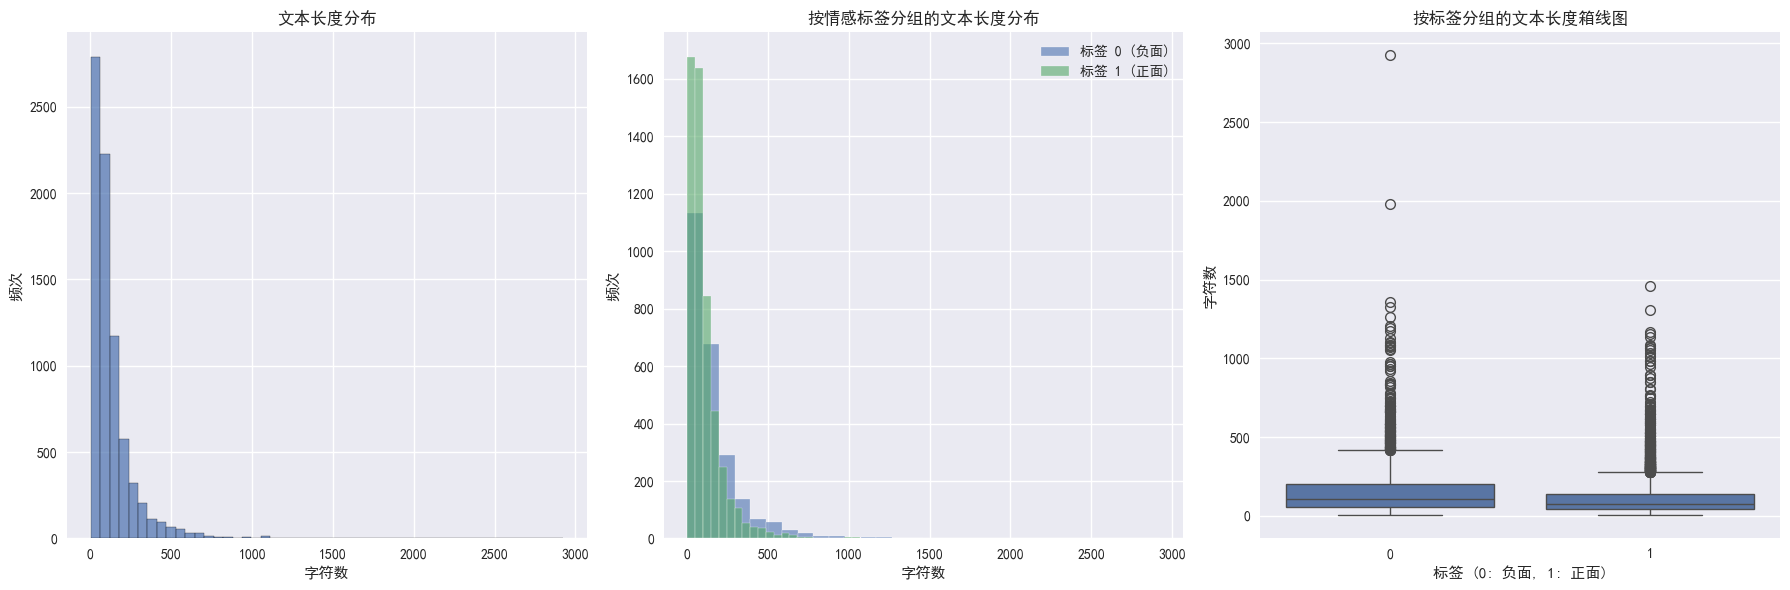

In [16]:
# 计算文本长度
df['text_length'] = df['review'].astype(str).apply(len)
df['word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))

# 文本长度统计
print("文本长度统计:")
print(df['text_length'].describe())

# 可视化文本长度分布
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 整体文本长度分布
axes[0].hist(df['text_length'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('文本长度分布')
axes[0].set_xlabel('字符数')
axes[0].set_ylabel('频次')

# 按标签分组的文本长度分布
for label in [0, 1]:
    subset = df[df['label'] == label]['text_length']
    axes[1].hist(subset, bins=30, alpha=0.6, 
                   label=f'标签 {label} ({"负面" if label == 0 else "正面"})')
axes[1].set_title('按情感标签分组的文本长度分布')
axes[1].set_xlabel('字符数')
axes[1].set_ylabel('频次')
axes[1].legend()

# 文本长度箱线图
sns.boxplot(data=df, x='label', y='text_length', ax=axes[2])
axes[2].set_title('按标签分组的文本长度箱线图')
axes[2].set_xlabel('标签 (0: 负面, 1: 正面)')
axes[2].set_ylabel('字符数')

plt.tight_layout()
plt.show()

不同长度区间的文本分布:
length_category
0-50        2198
51-100      2297
101-200     1964
201-500     1085
501-1000     192
1000+         30
Name: count, dtype: int64


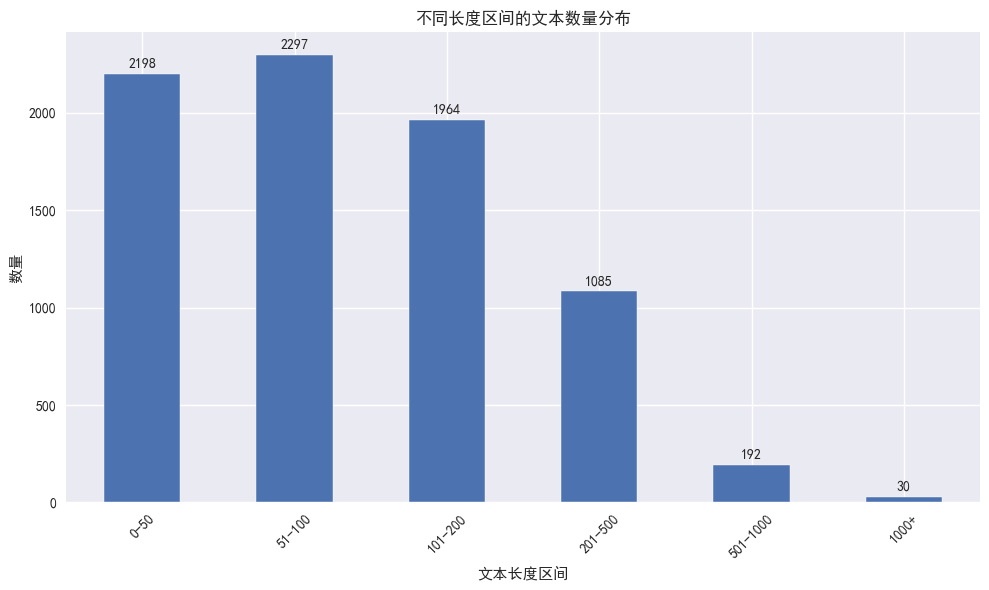

In [17]:
# 统计不同长度区间的文本数量
length_bins = [0, 50, 100, 200, 500, 1000, float('inf')]
length_labels = ['0-50', '51-100', '101-200', '201-500', '501-1000', '1000+']

df['length_category'] = pd.cut(df['text_length'], bins=length_bins, labels=length_labels)

print("不同长度区间的文本分布:")
length_dist = df['length_category'].value_counts().sort_index()
print(length_dist)

# 可视化
plt.figure(figsize=(10, 6))
length_dist.plot(kind='bar')
plt.title('不同长度区间的文本数量分布')
plt.xlabel('文本长度区间')
plt.ylabel('数量')
plt.xticks(rotation=45)

# 添加数值标签
for i, v in enumerate(length_dist.values):
    plt.text(i, v + 20, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 4. 文本内容分析

In [18]:
# 随机展示一些评论样本
print("=== 正面评论样本 ===")
positive_samples = df[df['label'] == 1]['review'].sample(5)
for i, review in enumerate(positive_samples, 1):
    print(f"{i}. {review}")
    print()

print("\n=== 负面评论样本 ===")
negative_samples = df[df['label'] == 0]['review'].sample(5)
for i, review in enumerate(negative_samples, 1):
    print(f"{i}. {review}")
    print()

=== 正面评论样本 ===
1. 物有所值。酒店气氛非常好。餐厅食品可口。房间整洁，环境豪华。

2. 酒店软硬件都不错，游泳池更不错。只是周围没有吃饭的地方，一定到打车出去。另外，酒店不让出租车在酒店门口待客，客人要走到马路上打车，是法国人的新招吗？同酒店服务的档次严重脱位。

3. 卫生很好，早餐一般，不过很便宜，只有15元。房间内拖鞋质量太差。餐厅提供的菜肴味道不错。

4. 住了一个晚上的大床房，总体感觉不好不坏。房间是超级大，还有吧台，不过对我来说没什么用处，装修感觉不够轻松。刚进房间放下包就有小姐打电话来问需不需要按摩服务，让人怀疑是不是酒店有什么猫腻。卫生间洗澡水超大，但是洗浴用品比较少，不过有一大堆乱七八糟的东西像什么安全套，一次性内裤，子等等要收费。地理位置倒还不错，交通还算方面。还有一点，早餐比较一般，而且位置太少了，等个位置吃早饭等了好久。补充点评2008年7月13日：忘记说了，房间内打长途竟然还要钱，而且宽带上网巨慢。

5. 酒店位置比较好,设施比较新,房间比较宽敞，服务尚可。


=== 负面评论样本 ===
1. 太烂了，房间小，门口停车还要收费，屋里霉味很重，不知道那些说好的人是怎么体验的。

2. 招待所而已吧，唯一可取之处就是交通还行，三环边上。

3. 特价房相当的吵。临近高价桥，晚上吵死拉。不过在背面的房间倒还不错，价格也很有吸引力。就是房间很旧！服务员态度一般，而且还很忙，入住和退房都等了很久，差不多10-30分钟才能搞定。

4. 这是我住过的最差的酒店，房间气味难闻，刚打了灭蚊药水，换了三个房间还是如此，服务员说：“住久了就习惯了，每个宾馆都有自己的味道。”考！我又不是来体验生活的。周围环境复杂，脏乱差。

5. 这个酒店太没有职业精神了！等半天打不到一辆taxi，结帐时没给发票……客房条件一般……性价比太低。以后肯定不会再住这酒店。早餐很差，周围环境很差。



In [19]:
# 分词和词频统计
def segment_text(text):
    """中文分词"""
    if pd.isna(text):
        return []
    # 清理文本
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9]', ' ', str(text))
    # 分词
    words = jieba.cut(text)
    # 过滤短词和停用词
    words = [word.strip() for word in words if len(word.strip()) > 1]
    return words

# 对所有文本进行分词
print("正在进行中文分词...")
df['words'] = df['review'].apply(segment_text)

# 统计总词频
all_words = []
for words in df['words']:
    all_words.extend(words)

word_freq = Counter(all_words)
print(f"总词汇数: {len(word_freq)}")
print(f"总词次数: {sum(word_freq.values())}")

print("\n最常见的20个词:")
for word, freq in word_freq.most_common(20):
    print(f"{word}: {freq}")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\23785\AppData\Local\Temp\jieba.cache
Loading model from cache C:\Users\23785\AppData\Local\Temp\jieba.cache


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\23785\AppData\Local\Temp\jieba.cache
Loading model from cache C:\Users\23785\AppData\Local\Temp\jieba.cache


正在进行中文分词...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\23785\AppData\Local\Temp\jieba.cache
Loading model from cache C:\Users\23785\AppData\Local\Temp\jieba.cache


正在进行中文分词...


Loading model cost 0.320 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\23785\AppData\Local\Temp\jieba.cache
Loading model from cache C:\Users\23785\AppData\Local\Temp\jieba.cache


正在进行中文分词...


Loading model cost 0.320 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.


总词汇数: 27580
总词次数: 316417

最常见的20个词:
酒店: 10055
房间: 6981
不错: 3885
服务: 3400
没有: 3177
我们: 2734
入住: 2651
可以: 2428
比较: 2353
感觉: 2044
早餐: 1996
就是: 1919
非常: 1861
还是: 1838
前台: 1748
一个: 1577
方便: 1562
携程: 1442
设施: 1437
服务员: 1409


In [20]:
# 按情感标签分别统计词频
positive_words = []
negative_words = []

for idx, words in enumerate(df['words']):
    if df.iloc[idx]['label'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_freq = Counter(positive_words)
negative_freq = Counter(negative_words)

print("正面评论中最常见的15个词:")
for word, freq in positive_freq.most_common(15):
    print(f"{word}: {freq}")

print("\n负面评论中最常见的15个词:")
for word, freq in negative_freq.most_common(15):
    print(f"{word}: {freq}")

正面评论中最常见的15个词:
酒店: 6249
房间: 4192
不错: 3621
服务: 2412
比较: 1910
可以: 1825
入住: 1595
感觉: 1530
我们: 1477
早餐: 1439
没有: 1436
就是: 1371
还是: 1326
非常: 1321
方便: 1318

负面评论中最常见的15个词:
酒店: 3806
房间: 2789
没有: 1741
我们: 1257
入住: 1056
服务: 988
前台: 933
携程: 861
一个: 844
服务员: 702
可以: 603
这个: 565
早餐: 557
客人: 556
就是: 548


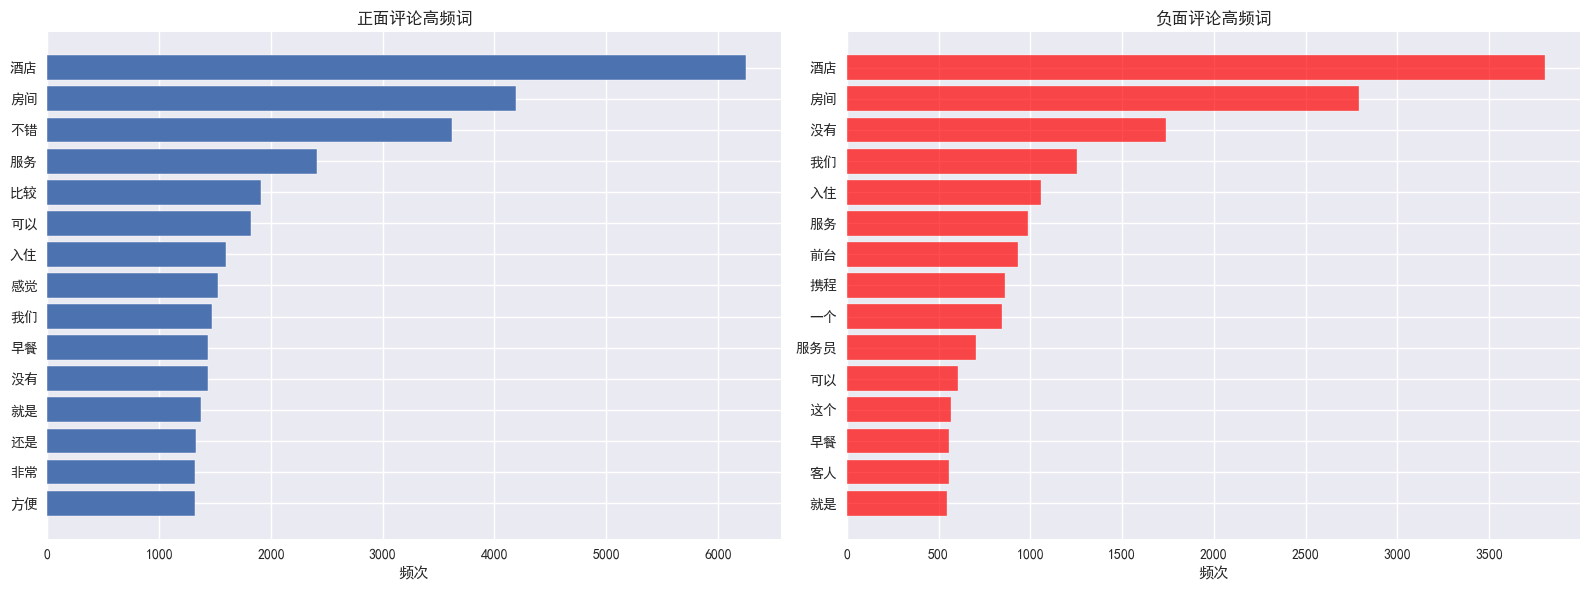

In [21]:
# 可视化词频分布
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 正面词频
pos_words, pos_freqs = zip(*positive_freq.most_common(15))
axes[0].barh(range(len(pos_words)), pos_freqs)
axes[0].set_yticks(range(len(pos_words)))
axes[0].set_yticklabels(pos_words)
axes[0].set_title('正面评论高频词')
axes[0].set_xlabel('频次')
axes[0].invert_yaxis()

# 负面词频
neg_words, neg_freqs = zip(*negative_freq.most_common(15))
axes[1].barh(range(len(neg_words)), neg_freqs, color='red', alpha=0.7)
axes[1].set_yticks(range(len(neg_words)))
axes[1].set_yticklabels(neg_words)
axes[1].set_title('负面评论高频词')
axes[1].set_xlabel('频次')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. 词云可视化

使用字体: C:/Windows/Fonts/simhei.ttf


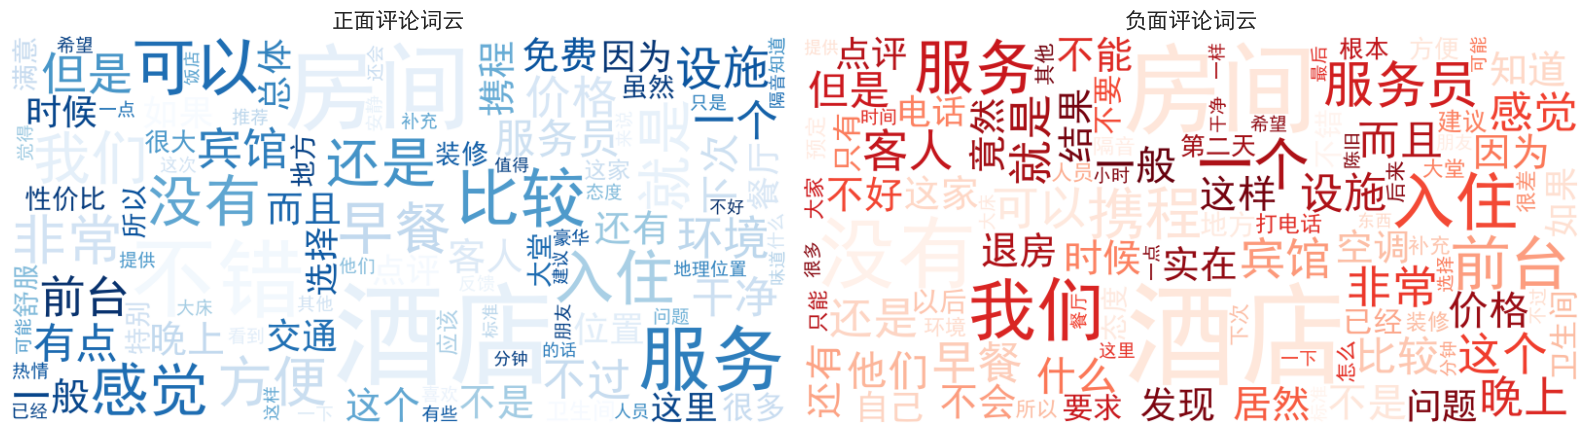

词云图片已保存到 ../results/wordcloud_analysis.png


In [25]:
# 生成词云
# 注意：需要先安装wordcloud库
# pip install wordcloud

import os
import platform

try:
    from wordcloud import WordCloud
    
    # 设置中文字体路径
    def get_chinese_font():
        """获取系统中文字体路径"""
        system = platform.system()
        if system == "Windows":
            font_paths = [
                "C:/Windows/Fonts/simhei.ttf",  # 黑体
                "C:/Windows/Fonts/msyh.ttc",    # 微软雅黑
                "C:/Windows/Fonts/simsun.ttc",  # 宋体
            ]
        elif system == "Darwin":  # macOS
            font_paths = [
                "/System/Library/Fonts/PingFang.ttc",
                "/System/Library/Fonts/STHeiti Light.ttc",
            ]
        else:  # Linux
            font_paths = [
                "/usr/share/fonts/truetype/wqy/wqy-microhei.ttc",
                "/usr/share/fonts/truetype/arphic/ukai.ttc",
            ]
        
        # 找到第一个存在的字体文件
        for font_path in font_paths:
            if os.path.exists(font_path):
                return font_path
        return None
    
    chinese_font = get_chinese_font()
    print(f"使用字体: {chinese_font}")
    
    # 正面评论词云
    positive_text = ' '.join(positive_words)
    wordcloud_pos = WordCloud(
        font_path=chinese_font,
        width=800, height=400,
        background_color='white',
        max_words=100,
        colormap='Blues',
        collocations=False,  # 避免重复词组
        relative_scaling=0.5,
        random_state=42
    ).generate(positive_text)
    
    # 负面评论词云
    negative_text = ' '.join(negative_words)
    wordcloud_neg = WordCloud(
        font_path=chinese_font,
        width=800, height=400,
        background_color='white',
        max_words=100,
        colormap='Reds',
        collocations=False,  # 避免重复词组
        relative_scaling=0.5,
        random_state=42
    ).generate(negative_text)
    
    # 显示词云
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(wordcloud_pos, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('正面评论词云', fontsize=16)
    
    axes[1].imshow(wordcloud_neg, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('负面评论词云', fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    # 保存词云图片
    try:
        os.makedirs('../results', exist_ok=True)
        fig.savefig('../results/wordcloud_analysis.png', dpi=300, bbox_inches='tight')
        print("词云图片已保存到 ../results/wordcloud_analysis.png")
    except Exception as e:
        print(f"保存图片时出错: {e}")
    
except ImportError:
    print("请安装wordcloud库：pip install wordcloud")
except Exception as e:
    print(f"生成词云时出错: {e}")
    print("如果遇到字体问题，请确保系统中安装了中文字体")

## 6. 特殊字符和模式分析

In [26]:
# 分析特殊字符和模式
def analyze_text_patterns(text):
    """分析文本模式"""
    if pd.isna(text):
        return {
            'has_emoji': False,
            'has_punctuation': False,
            'has_english': False,
            'has_numbers': False,
            'exclamation_count': 0,
            'question_count': 0
        }
    
    text = str(text)
    
    return {
        'has_emoji': bool(re.search(r'[😀-🙏]', text)),
        'has_punctuation': bool(re.search(r'[！？。，；：]', text)),
        'has_english': bool(re.search(r'[a-zA-Z]', text)),
        'has_numbers': bool(re.search(r'\d', text)),
        'exclamation_count': text.count('！') + text.count('!'),
        'question_count': text.count('？') + text.count('?')
    }

# 应用模式分析
pattern_analysis = df['review'].apply(analyze_text_patterns)
pattern_df = pd.DataFrame(pattern_analysis.tolist())

# 合并到原数据框
df = pd.concat([df, pattern_df], axis=1)

# 统计各种模式的出现频率
print("文本模式统计:")
print(f"包含表情符号: {df['has_emoji'].sum()} ({df['has_emoji'].mean():.2%})")
print(f"包含标点符号: {df['has_punctuation'].sum()} ({df['has_punctuation'].mean():.2%})")
print(f"包含英文字符: {df['has_english'].sum()} ({df['has_english'].mean():.2%})")
print(f"包含数字: {df['has_numbers'].sum()} ({df['has_numbers'].mean():.2%})")
print(f"平均感叹号数量: {df['exclamation_count'].mean():.2f}")
print(f"平均问号数量: {df['question_count'].mean():.2f}")

文本模式统计:
包含表情符号: 0 (0.00%)
包含标点符号: 6223 (80.13%)
包含英文字符: 951 (12.25%)
包含数字: 3598 (46.33%)
平均感叹号数量: 0.75
平均问号数量: 0.12


In [27]:
# 按情感标签分析文本模式
print("按情感标签分组的文本模式分析:")
for label in [0, 1]:
    subset = df[df['label'] == label]
    label_name = "负面" if label == 0 else "正面"
    print(f"\n{label_name}评论:")
    print(f"  包含标点符号: {subset['has_punctuation'].mean():.2%}")
    print(f"  包含英文字符: {subset['has_english'].mean():.2%}")
    print(f"  包含数字: {subset['has_numbers'].mean():.2%}")
    print(f"  平均感叹号数量: {subset['exclamation_count'].mean():.2f}")
    print(f"  平均问号数量: {subset['question_count'].mean():.2f}")
    print(f"  平均文本长度: {subset['text_length'].mean():.1f}")

按情感标签分组的文本模式分析:

负面评论:
  包含标点符号: 80.85%
  包含英文字符: 13.63%
  包含数字: 56.10%
  平均感叹号数量: 1.30
  平均问号数量: 0.25
  平均文本长度: 164.3

正面评论:
  包含标点符号: 79.80%
  包含英文字符: 11.61%
  包含数字: 41.85%
  平均感叹号数量: 0.50
  平均问号数量: 0.07
  平均文本长度: 112.1


## 7. 数据质量评估

In [28]:
# 检查数据质量问题
print("数据质量评估:")

# 1. 重复评论
duplicate_reviews = df['review'].duplicated().sum()
print(f"重复评论数量: {duplicate_reviews}")

# 2. 过短评论
very_short = (df['text_length'] < 10).sum()
print(f"过短评论（<10字符）数量: {very_short}")

# 3. 过长评论
very_long = (df['text_length'] > 1000).sum()
print(f"过长评论（>1000字符）数量: {very_long}")

# 4. 空白或无意义评论
empty_or_meaningless = df['review'].astype(str).str.strip().str.len() == 0
print(f"空白评论数量: {empty_or_meaningless.sum()}")

# 展示一些问题数据样本
if duplicate_reviews > 0:
    print("\n重复评论示例:")
    duplicates = df[df['review'].duplicated(keep=False)]['review'].unique()[:3]
    for i, dup in enumerate(duplicates, 1):
        print(f"{i}. {dup}")

if very_short > 0:
    print("\n过短评论示例:")
    short_reviews = df[df['text_length'] < 10]['review'].head(3)
    for i, review in enumerate(short_reviews, 1):
        print(f"{i}. {review}")

数据质量评估:
重复评论数量: 0
过短评论（<10字符）数量: 10
过长评论（>1000字符）数量: 30
空白评论数量: 0

过短评论示例:
1. 房间设施不
2. 酒店房间
3. 酒店地理位


## 8. 总结和建议

In [15]:
# 数据集总结
print("=== 数据集总结 ===")
print(f"数据集大小: {len(df):,} 条评论")
print(f"正面评论: {(df['label'] == 1).sum():,} 条 ({(df['label'] == 1).mean():.1%})")
print(f"负面评论: {(df['label'] == 0).sum():,} 条 ({(df['label'] == 0).mean():.1%})")
print(f"平均文本长度: {df['text_length'].mean():.1f} 字符")
print(f"文本长度中位数: {df['text_length'].median():.1f} 字符")
print(f"词汇总数: {len(word_freq):,} 个不同词汇")

print("\n=== 数据预处理建议 ===")
print("1. 数据基本平衡，无需特殊采样处理")
print("2. 文本长度差异较大，建议设置合适的最大长度截断")
print("3. 包含标点符号和数字，需要考虑是否保留")
print("4. 建议移除重复评论和过短评论")
print("5. 可以考虑使用分词结果辅助BERT模型")

print("\n=== 建议的数据预处理参数 ===")
print(f"推荐最大序列长度: {int(df['text_length'].quantile(0.95))} (覆盖95%数据)")
print(f"最小文本长度阈值: 10 字符")
print(f"批处理大小建议: 16-32")

=== 数据集总结 ===
数据集大小: 7,766 条评论
正面评论: 5,322 条 (68.5%)
负面评论: 2,444 条 (31.5%)
平均文本长度: 128.5 字符
文本长度中位数: 84.0 字符
词汇总数: 27,580 个不同词汇

=== 数据预处理建议 ===
1. 数据基本平衡，无需特殊采样处理
2. 文本长度差异较大，建议设置合适的最大长度截断
3. 包含标点符号和数字，需要考虑是否保留
4. 建议移除重复评论和过短评论
5. 可以考虑使用分词结果辅助BERT模型

=== 建议的数据预处理参数 ===
推荐最大序列长度: 383 (覆盖95%数据)
最小文本长度阈值: 10 字符
批处理大小建议: 16-32


In [16]:
# 保存分析结果
analysis_summary = {
    'dataset_size': len(df),
    'positive_count': int((df['label'] == 1).sum()),
    'negative_count': int((df['label'] == 0).sum()),
    'avg_text_length': float(df['text_length'].mean()),
    'median_text_length': float(df['text_length'].median()),
    'vocabulary_size': len(word_freq),
    'duplicate_count': int(duplicate_reviews),
    'short_text_count': int(very_short),
    'long_text_count': int(very_long),
    'recommended_max_length': int(df['text_length'].quantile(0.95)),
    'top_positive_words': positive_freq.most_common(20),
    'top_negative_words': negative_freq.most_common(20)
}

# 保存到文件
import json
with open('../data/analysis/eda_summary.json', 'w', encoding='utf-8') as f:
    json.dump(analysis_summary, f, ensure_ascii=False, indent=2)

print("分析结果已保存到 ../data/analysis/eda_summary.json")

分析结果已保存到 ../data/analysis/eda_summary.json
